# Deep Learning with PyTorch : Build a Generative Adversarial Network

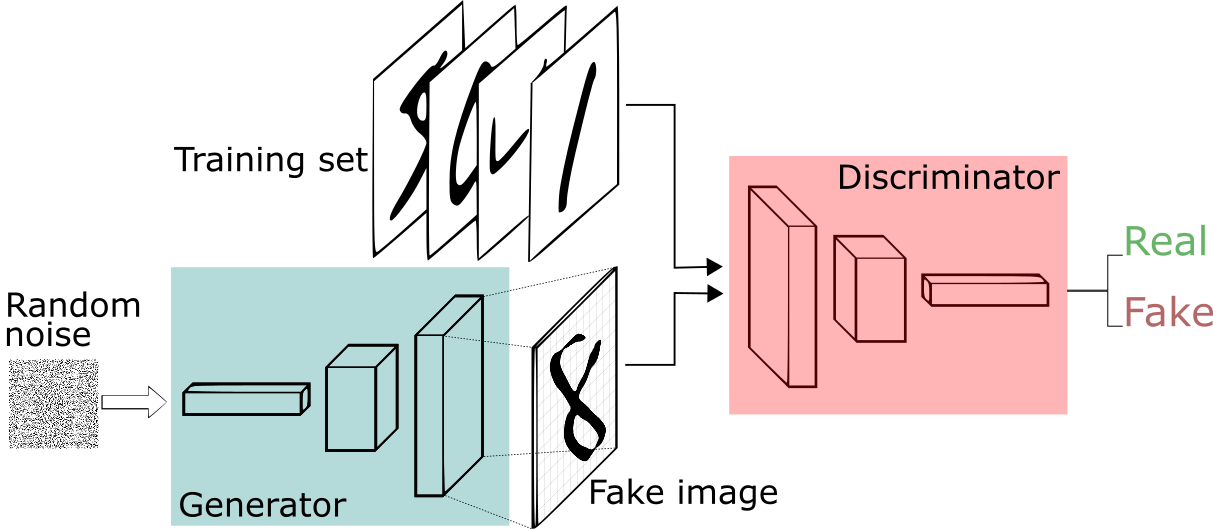

In [1]:
import torch
torch.manual_seed(42)
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

# Configurations

In [2]:
device='cuda'
batch_size=128
noise_dim=64

lr=0.0002
beta_1=0.5
beta_2=0.99

epochs=20

# Load MNIST Dataset

In [5]:
from torchvision import datasets, transforms as T

In [6]:
train_augs=T.Compose([
    T.RandomRotation((-20, 20)),
    T.ToTensor()
])

In [7]:
trainset=datasets.MNIST('MNSIT/ ', train=True, download=True, transform=train_augs)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.56MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 131kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.23MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.27MB/s]


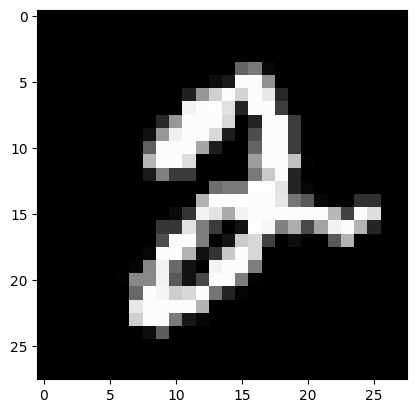

In [8]:
image,label=trainset[5]
plt.imshow(image.squeeze(), cmap='gray')
plt.show()

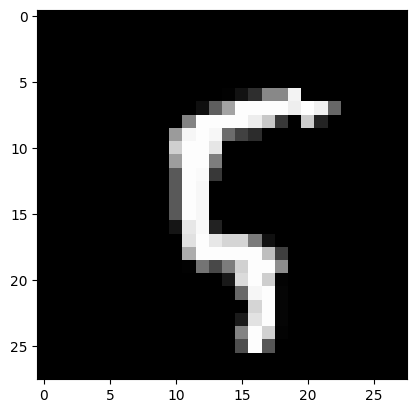

In [10]:
image,label=trainset[100]
plt.imshow(image.squeeze(), cmap='gray')
plt.show()

In [11]:
len(trainset)

60000

# Load Dataset Into Batches

In [12]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [13]:
train_loader=DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [14]:
print(total_batches := len(train_loader))

469


In [16]:
dataiter=iter(train_loader)
images,_=next(dataiter)
print(images.shape)

torch.Size([128, 1, 28, 28])


In [17]:
# 'show_tensor_images' : function is used to plot some of images from the batch

def show_tensor_images(tensor_img, num_images = 16, size=(1, 28, 28)):
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_images], nrow=4)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

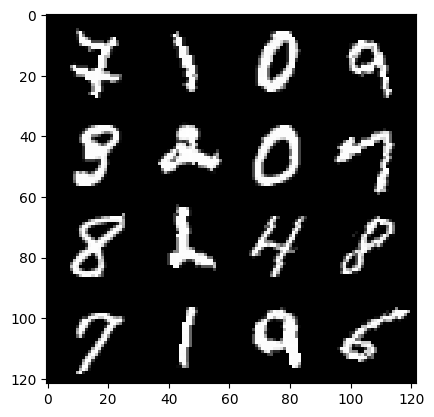

In [18]:
show_tensor_images(images)

# Create Discriminator Network

In [19]:
#In case if torch summary is not installed

!pip install torchsummary

In [20]:
from torch import nn
from torchsummary import summary

In [ ]:
'''

Network : Discriminator

input : (bs, 1, 28, 28)
      |                                                                                               ---- SUMMARY ----
      V
Conv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)
BatchNorm2d()                                                                                          #(bs, 16, 13, 13)
LeakyReLU()                                                                                            #(bs, 16, 13, 13)
      |
      V
Conv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)
BatchNorm2d()                                                                                          #(bs, 32, 5, 5)
LeakyReLU()                                                                                            #(bs, 32, 5, 5)
      |
      V
Conv2d( in_channels = 32, out_channels = 64, kernel_size = (5,5), stride = 2)                          #(bs, 64, 1, 1)
BatchNorm2d()                                                                                          #(bs, 64, 1, 1)
LeakyReLU()                                                                                            #(bs, 64, 1, 1)
      |
      V
Flatten()                                                                                              #(bs, 64)
Linear(in_features = 64, out_features = 1)                                                             #(bs, 1)

'''

In [21]:
def get_disc_block(in_channels, out_channels, kernel_size, stride):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(0.2)
    )

In [22]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.block_1=get_disc_block(1, 16, (3,3), 2)
        self.block_2=get_disc_block(16, 32,(5,5),2)
        self.block_3=get_disc_block(32, 64,(5,5),2)

        self.flatten=nn.Flatten()
        self.linear=nn.Linear(64,1)

    def forward(self, images):
        x1=self.block_1(images)
        x2=self.block_2(x1)
        x3=self.block_3(x2)
        x4=self.flatten(x3)
        x5=self.linear(x4)

        return x5

In [23]:
D=Discriminator()
summary(D.to(device), (1,28,28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             160
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 5, 5]          12,832
       BatchNorm2d-5             [-1, 32, 5, 5]              64
         LeakyReLU-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 64, 1, 1]          51,264
       BatchNorm2d-8             [-1, 64, 1, 1]             128
         LeakyReLU-9             [-1, 64, 1, 1]               0
          Flatten-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 64,545
Trainable params: 64,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

# Create Generator Network

In [ ]:
'''

Network : Generator

z_dim = 64
input : (bs,z_dim)

      |
      | Reshape
      V

input : (bs, channel, height, width) -> (bs, z_dim , 1 , 1)
      |                                                                                               ---- SUMMARY ----
      V
ConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)
BatchNorm2d()                                                                                          #(bs, 256, 3, 3)
ReLU()                                                                                                 #(bs, 256, 3, 3)
      |
      V
ConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)
BatchNorm2d()                                                                                          #(bs, 128, 6, 6)
ReLU()                                                                                                 #(bs, 128, 6, 6)
      |
      V
ConvTranspose2d( in_channels = 128, out_channels = 64, kernel_size = (3,3), stride = 2)                #(bs, 64, 13, 13)
BatchNorm2d()                                                                                          #(bs, 64, 13, 13)
ReLU()                                                                                                 #(bs, 64, 13, 13)
      |
      V
ConvTranspose2d( in_channels = 64, out_channels = 1, kernel_size = (4,4), stride = 2)                  #(bs, 1, 28, 28)
Tanh()                                                                                                 #(bs, 1, 28, 28)

'''

In [24]:
def get_gen_block(in_channels, out_channels, kernel_size, stride,final_block=False):
    if final_block==True:
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
            nn.Tanh()
        )
    else:
      return nn.Sequential(
          nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
          nn.BatchNorm2d(out_channels)
          ,nn.ReLU()
      )

In [25]:
class Generator(nn.Module):
    def __init__(self, noise_dim):
        super(Generator, self).__init__()
        self.noise_dim=noise_dim
        self.block1=get_gen_block(noise_dim, 256, (3,3), 2)
        self.block2=get_gen_block(256, 128, (4,4), 1)
        self.block3=get_gen_block(128, 64, (3,3), 2)
        self.block4=get_gen_block(64, 1, (4,4), 2, final_block=True)

    def forward(self, r_noise_vec):

        x=r_noise_vec.view(-1, self.noise_dim, 1, 1)
        x1=self.block1(x)
        x2=self.block2(x1)
        x3=self.block3(x2)
        x4=self.block4(x3)

        return x4

In [26]:
G=Generator(noise_dim)
summary(G.to(device), (noise_dim,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         147,712
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
              ReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 747,841
Trainable params: 747,841
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [27]:
# Replace Random initialized weights to Normal weights

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

In [29]:
D=D.apply(weights_init)
G=G.apply(weights_init)

# Create Loss Function and Load Optimizer

In [30]:
def real_loss(disc_pred):
  criterion=nn.BCEWithLogitsLoss()
  ground_truth=torch.ones_like(disc_pred)
  loss=criterion(disc_pred, torch.ones_like(disc_pred))
  return loss

def fake_loss(disc_pred):
  criterion=nn.BCEWithLogitsLoss()
  ground_truth=torch.zeros_like(disc_pred)
  loss=criterion(disc_pred, torch.zeros_like(disc_pred))
  return loss

In [31]:
D_opt=torch.optim.Adam(D.parameters(), lr=lr, betas=(beta_1, beta_2))
G_opt=torch.optim.Adam(G.parameters(), lr=lr, betas=(beta_1, beta_2))

# Training Loop

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:1|D_loss:0.6784266061874341|G_loss=0.7064589567021775


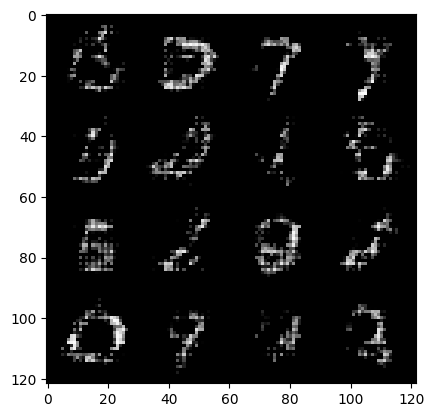

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:2|D_loss:0.634987084469053|G_loss=0.7574047071338971


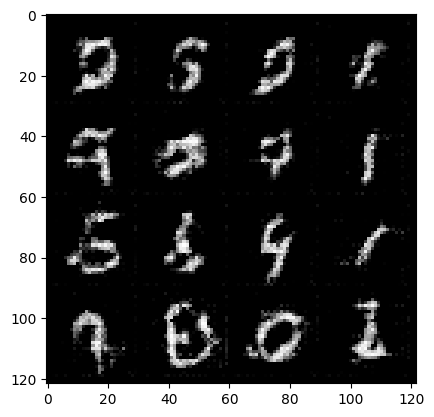

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:3|D_loss:0.5935716584547243|G_loss=0.8157943394392538


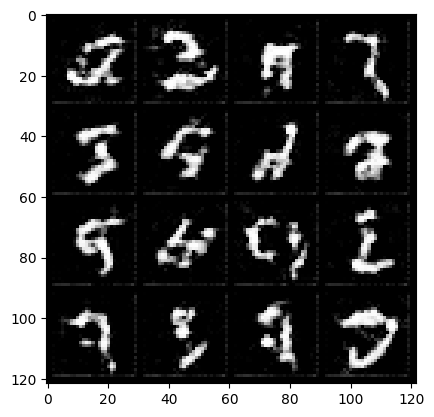

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:4|D_loss:0.5731991539631826|G_loss=0.8573253144587535


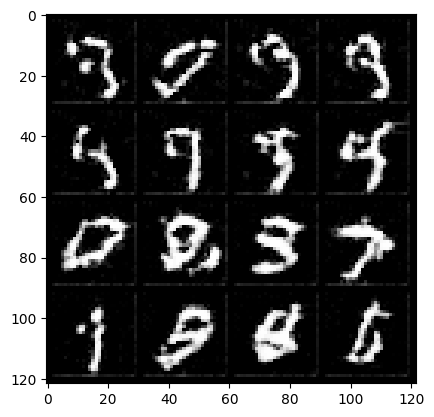

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:5|D_loss:0.5731772385172244|G_loss=0.869755103262757


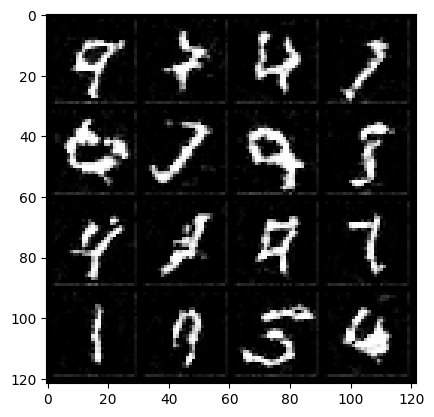

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:6|D_loss:0.5853773574076736|G_loss=0.8669323158670844


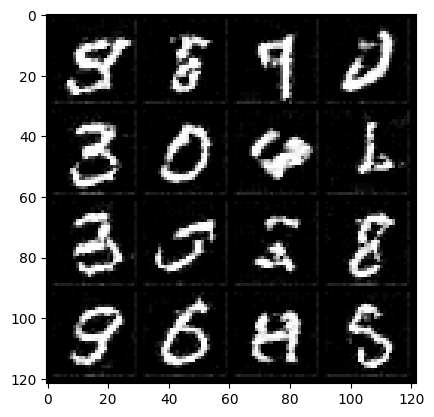

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:7|D_loss:0.6010236887535306|G_loss=0.855234781053783


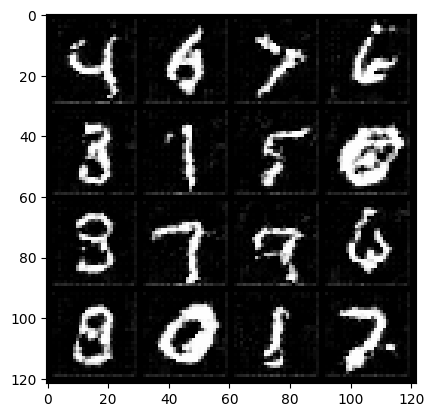

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:8|D_loss:0.6102288036204097|G_loss=0.8470634042835439


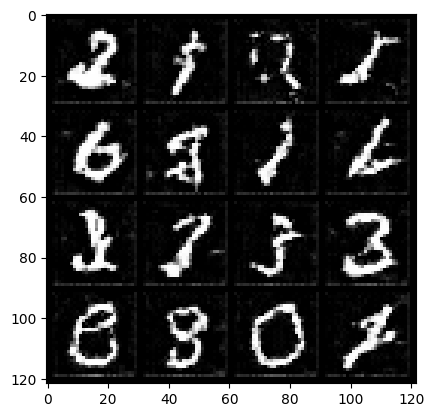

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:9|D_loss:0.6159767868168065|G_loss=0.8438887865558616


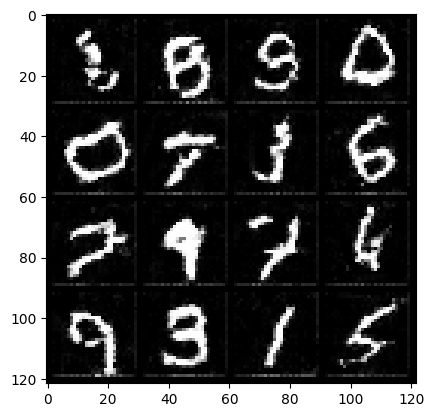

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:10|D_loss:0.6201153388663904|G_loss=0.8419237671884646


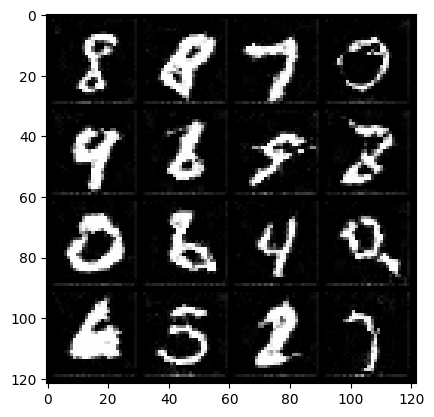

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:11|D_loss:0.6224948507127985|G_loss=0.8399464109304872


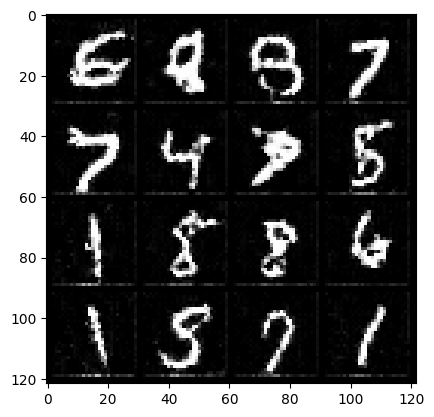

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:12|D_loss:0.6252749141599578|G_loss=0.8387226941488953


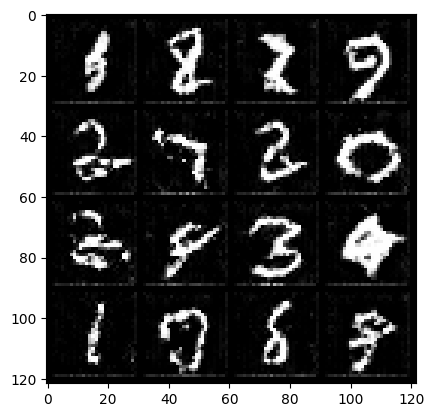

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:13|D_loss:0.6258782951562389|G_loss=0.8409440010341246


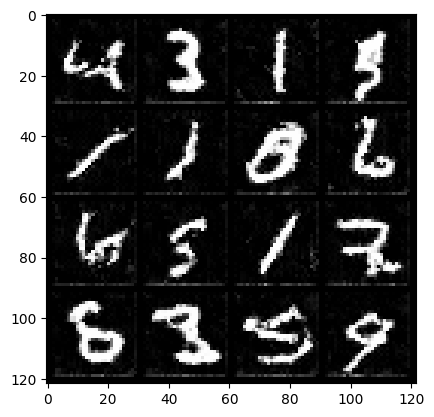

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:14|D_loss:0.6262810764028065|G_loss=0.8421986025533696


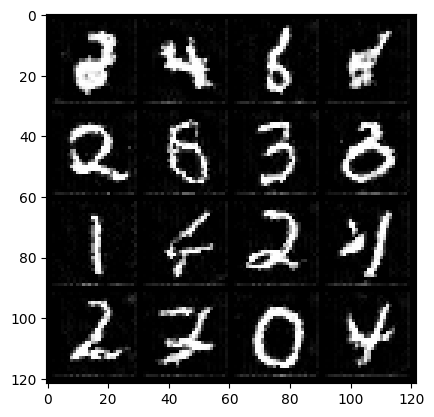

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:15|D_loss:0.6269585579188902|G_loss=0.8409204927843008


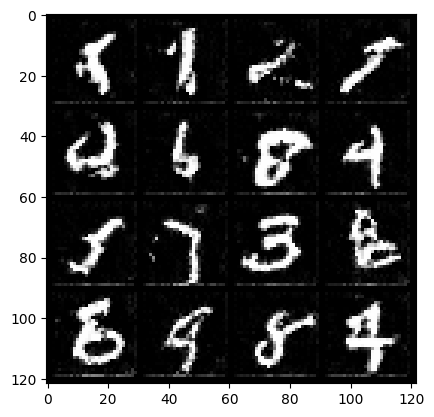

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:16|D_loss:0.6281643597556076|G_loss=0.8444302958974452


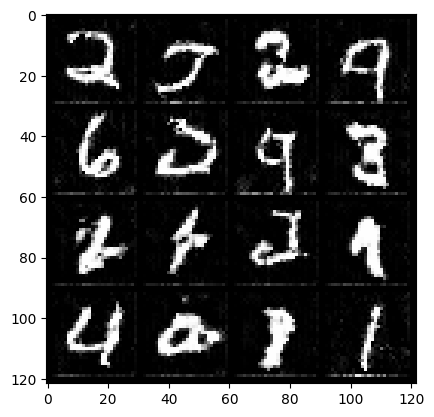

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:17|D_loss:0.6293194185950355|G_loss=0.8454817804192175


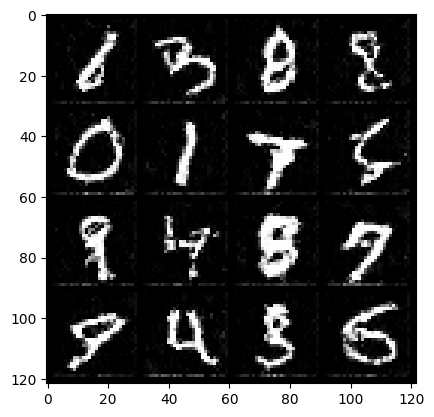

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:18|D_loss:0.6271068945622393|G_loss=0.8467252729798177


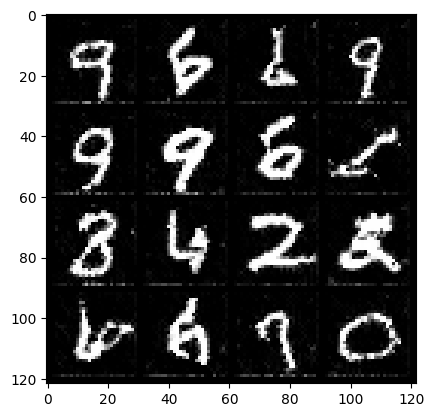

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:19|D_loss:0.6285149484300918|G_loss=0.8493899619147214


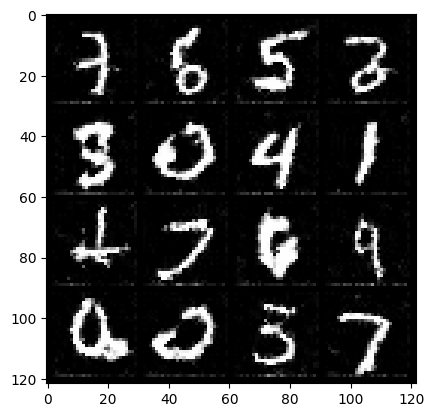

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:20|D_loss:0.6267073262474938|G_loss=0.8490748265658868


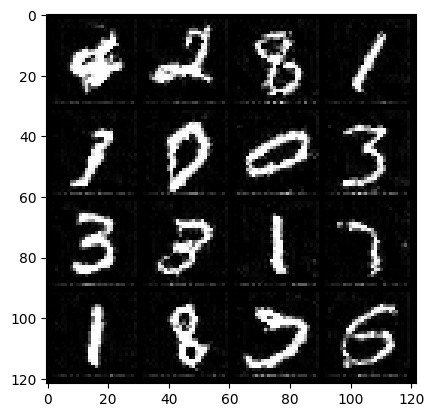

In [33]:
for i in range(epochs):
  total_d_loss=0.0
  total_g_loss=0.0
  for real_img,_ in tqdm(train_loader):

    real_img=real_img.to(device)
    noise=torch.randn(batch_size, noise_dim, device=device)
    D_opt.zero_grad()
    fake_img=G(noise)
    D_pred=D(fake_img)
    D_fake_loss=fake_loss(D_pred)

    D_pred=D(real_img)
    D_real_loss=real_loss(D_pred)

    D_loss=(D_fake_loss+D_real_loss)/2
    total_d_loss+=D_loss.item()
    D_loss.backward()
    D_opt.step()

    G_opt.zero_grad()
    noise=torch.randn(batch_size, noise_dim, device=device)
    fake_img=G(noise)
    D_pred=D(fake_img)
    G_loss=real_loss(D_pred)
    total_g_loss+=G_loss.item()
    G_loss.backward()
    G_opt.step()

  avg_d_loss=total_d_loss/total_batches
  avg_g_loss=total_g_loss/total_batches

  print("Epoch:{}|D_loss:{}|G_loss={}".format(i+1,avg_d_loss,avg_g_loss))
  show_tensor_images(fake_img)

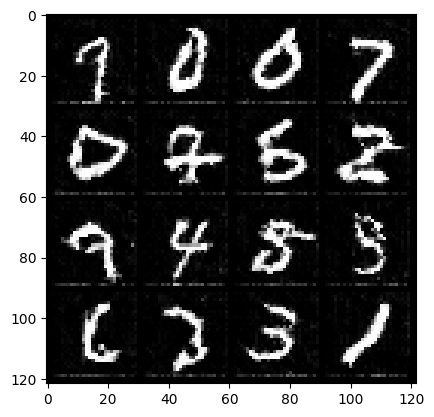

In [34]:
# Run after training is completed.
# Now you can use Generator Network to generate handwritten images

noise = torch.randn(batch_size, noise_dim, device = device)
generated_image = G(noise)

show_tensor_images(generated_image)